# 测试LSTM

In [1]:
import torch
import torch.nn as nn
import numpy as np


## 定义模型

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out, hn


## 文本预处理和向量化
通常，我们会将文本转换为词嵌入向量。这里假设我们使用预训练的词嵌入（如GloVe），或者你可以使用简单的词汇索引加上嵌入层

In [16]:
# 假设我们有一个简单的词汇表和对应的嵌入矩阵
vocab = {'hello': 0, 'world': 1}
# 嵌入矩阵的形状是 (vocab_size, embedding_dim)
embedding_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])  # 简单的嵌入矩阵示例

def text_to_tensor(text, vocab, embedding_matrix):
    # 这一步将输入文本转换为小写，并根据空格进行分词，生成单词列表。例如，输入文本 "Hello World" 将变成 ['hello', 'world']
    tokens = text.split()
    # print(f"tokens: {tokens}")
    # 这一步通过词汇表（vocab）将每个单词转换为其对应的索引，生成索引列表。这里使用列表推导式，只保留在词汇表中的单词。
    # 例如，对于 ['hello', 'world']，如果 vocab 是 {'hello': 0, 'world': 1}，那么生成的索引列表将是 [0, 1]
    indices = [vocab[token] for token in tokens if token in vocab]
    # print(f"indices: {indices}")
    # 这一步使用索引列表从嵌入矩阵中提取相应的嵌入向量
    # 如果 embedding_matrix 是：np.array([[1, 2, 3], [4, 5, 6]])，那么 indices = [0, 1] 将生成嵌入向量：np.array([[1, 2, 3], [4, 5, 6]])
    embeds = embedding_matrix[indices]
    # print(f"embeds: {embeds}")
    # 最后，将嵌入向量转换为PyTorch张量，并将其维度从 (sequence_length, embedding_dim) 转换为 (1, sequence_length, embedding_dim)，以便适应LSTM的输入格式。
    # unsqueeze(0) 在第一个维度上添加一个维度，从而表示一个batch的样本
    return torch.tensor(embeds, dtype=torch.float32).unsqueeze(0)  # 添加batch维度


In [20]:
text = "I like dogs"
vocab1 = {'I': 0, 'like': 1, 'dogs': 2}
input_tensor = text_to_tensor(text, vocab1, embedding_matrix)
print(input_tensor)

tensor([[[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])


## 加载模型和提取特征

In [19]:
# 超参数
input_dim = 3  # 词嵌入维度
hidden_dim = 10
layer_dim = 1
output_dim = 1

# 初始化模型
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# 示例文本
text = "hello world"

# 将文本转换为tensor
input_tensor = text_to_tensor(text, vocab, embedding_matrix)

# 前向传播
output, hidden = model(input_tensor)

print("提取的特征：", hidden)


提取的特征： tensor([[[ 0.0642, -0.1354, -0.1168,  0.0246,  0.0140, -0.2269,  0.0067,
           0.0873,  0.0333, -0.0945]]], grad_fn=<StackBackward0>)


# 测试ResNet50

ResNet50作为图像编码器进行特征提取时，提取出来的特征通常是一个高维的张量（tensor）。具体来说，提取的特征可以被认为是一个高维向量或者特征图，取决于你从网络中提取特征的位置。
## 特征类型
1. **特征图（Feature Map）：**
    如果你从ResNet50的中间层或最后一个卷积层（通常是Global Average Pooling之前）提取特征，得到的将是一个高维特征图。特征图通常是一个四维张量，形状为 (batch_size, channels, height, width)。
2. **向量（Vector）：**
    如果你从Global Average Pooling层或之后的全连接层提取特征，得到的将是一个高维向量。通常情况下，这个向量表示了整个图像的全局特征，形状为 (batch_size, feature_dim)。

In [24]:
from torchvision.models import ResNet50_Weights
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 加载预训练的ResNet50模型
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 将模型设置为评估模式
model.eval()

# 定义图像转换
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载并预处理图像
img = Image.open("../image/2.jpg")
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)  # 添加batch维度

# 提取特征
with torch.no_grad():
    features = model(batch_t)

print("提取的特征形状:", features.shape)


提取的特征形状: torch.Size([1, 1000])


## 提取不同层的特征
如果你希望从ResNet50的不同层提取特征，可以修改模型，创建一个新的模型，该模型截断到你需要的层。例如：

In [25]:
# 从最后一个卷积层提取特征
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])  # 去掉最后的全局池化和全连接层
    
    def forward(self, x):
        x = self.features(x)
        return x

# 创建特征提取模型
feature_extractor = FeatureExtractor(model)

# 提取特征图
with torch.no_grad():
    feature_maps = feature_extractor(batch_t)

print("提取的特征图形状:", feature_maps.shape)  # 通常形状为(batch_size, 2048, 7, 7)


提取的特征图形状: torch.Size([1, 2048, 7, 7])


## 结论
特征图（Feature Map）：形状通常为 (batch_size, channels, height, width)，例如 (1, 2048, 7, 7)。
向量（Vector）：形状通常为 (batch_size, feature_dim)，例如 (1, 1000)，如果提取自最终的全连接层。

要打印或可视化ResNet50提取的特征图，可以通过以下步骤实现：

1. 提取特征图：从ResNet50的某个卷积层提取特征图。
2. 处理特征图：将特征图转换为可视化格式。
3. 显示特征图：使用Python图像库（如Matplotlib）显示特征图。

提取的特征图形状: torch.Size([1, 2048, 7, 7])


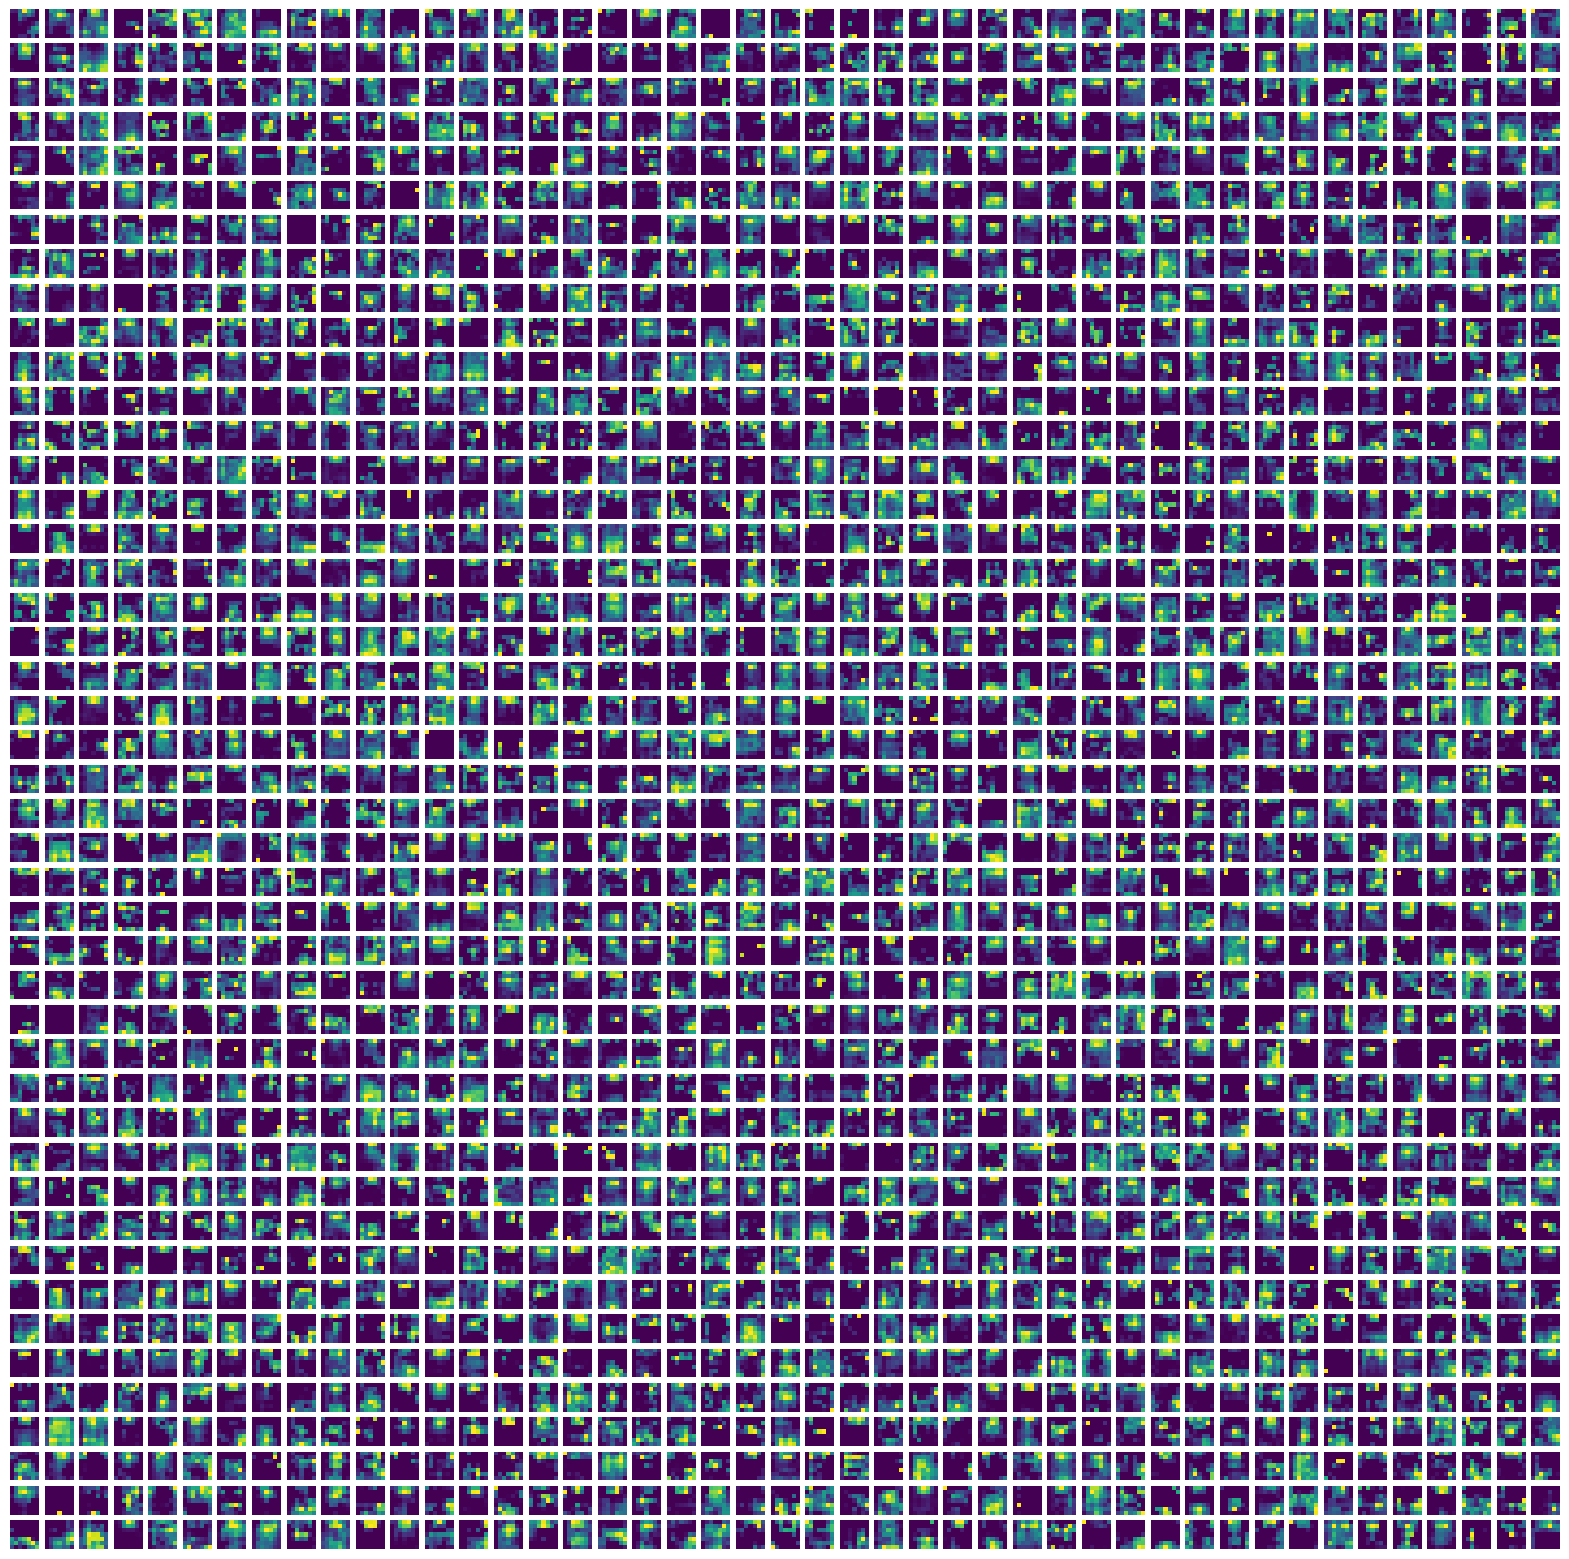

In [27]:
import torch
from torchvision.models import ResNet50_Weights
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 加载预训练的ResNet50模型
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 将模型设置为评估模式
model.eval()

# 定义图像转换
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载并预处理图像
img = Image.open("../image/2.jpg")
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)  # 添加batch维度

# 从最后一个卷积层提取特征
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])  # 去掉最后的全局池化和全连接层
    
    def forward(self, x):
        x = self.features(x)
        return x

# 创建特征提取模型
feature_extractor = FeatureExtractor(model)

# 提取特征图
with torch.no_grad():
    feature_maps = feature_extractor(batch_t)

print("提取的特征图形状:", feature_maps.shape)  # 通常形状为(batch_size, 2048, 7, 7)

# 可视化特征图
def visualize_feature_map(feature_map):
    feature_map = feature_map.squeeze(0)  # 去掉batch维度
    num_channels = feature_map.shape[0]
    
    # 创建一个大图用于显示所有通道的特征图
    fig, axes = plt.subplots(int(np.sqrt(num_channels)), int(np.sqrt(num_channels)), figsize=(20, 20))
    
    for i, ax in enumerate(axes.flat):
        if i < num_channels:
            fm = feature_map[i].cpu().numpy()
            ax.imshow(fm, cmap='viridis')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.show()

visualize_feature_map(feature_maps)


In [2]:
import torch
import torch

# Check if CUDA (GPU support) is available
gpu_available = torch.cuda.is_available()

gpu_available


False